The code in the following sections comes mainly from [this repository](https://github.com/tkipf/pygcn) and it is inspired by the paper [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907), where Thomas Kipf presents the Graph Convolutional Networks in PyTorch.

In [29]:
import pandas
import numpy as np
import scipy.sparse as sp
import torch


#The Cora Dataset

##Datset format

The `cora.content` contains the description of each node. For each line it contains:
 - The id of the node.
 - The [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) text representation.
 - The label of that node.

In [30]:
headers = ['PaperID'] + [f'word{i}' for i in range(1433)] + ['label']
cora_content=pandas.read_csv('cora.content', sep="\t", names=headers)
cora_content.head()

,PaperID,word0,word1,word2,word3,word4,word5,word6,word7,word8,...,word1424,word1425,word1426,word1427,word1428,word1429,word1430,word1431,word1432,label
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


The `cora.cites` contains the relationships between nodes. For each line it contains:

- The first entry is id of the cited paper
- The second entry id of the citing paper

That is, the direction of the entry is right to left.

In [31]:
headers = ['Cited PaperID', 'Citing PaperID']
cora_cites=pandas.read_csv('cora.cites', sep="\t", names=headers)
cora_cites.head()

,Cited PaperID,Citing PaperID
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [32]:
classes = [
    'Case_Based',
    'Genetic_Algorithms',
    'Neural_Networks',
    'Probabilistic_Methods',
    'Reinforcement_Learning',
    'Rule_Learning',
    'Theory',
]

## Dataset Loading

Until now we have seen building graphs in networkx. However in Pytorch, we need the data in the form of tensors. For this, we need some pre-processing

In [33]:
def encode_onehot(labels):
    """ Converts categorical labels into a one-hot encoded format"""
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot

In [34]:
ef normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1)) # 1. Calculate the sum of each row
    r_inv = np.power(rowsum, -1).flatten() # 2. Calculate the inverse of each row sum
    r_inv[np.isinf(r_inv)] = 0. # 3. Handle cases where the row sum was zero
    r_mat_inv = sp.diags(r_inv) # 4. Create a diagonal sparse matrix with the inverse row sums
    mx = r_mat_inv.dot(mx) # 5. Multiply the inverse diagonal matrix by the original sparse matrix
    return mx # 6. Return the row-normalized sparse matrix

#Row-normalizes a sparse matrix.
#To ensure that the sum of weights for edges originating from a node is 1.

In [35]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse_coo_tensor(indices, values, shape)

In [36]:
def load_data(cora_cites, cora_content):
    """Load citation network dataset from pandas DataFrames."""
    print('Loading dataset from DataFrames...')

    # Extract data from cora_content DataFrame
    idx_features_labels = cora_content.values
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}

    # Extract data from cora_cites DataFrame and build edges
    edges_unordered = cora_cites.values
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))

    idx_train = range(140)
    idx_val = range(200, 500)
    idx_test = range(500, 1500)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test

# Now you can call the function with your existing dataframes:
# adj, features, labels, idx_train, idx_val, idx_test = load_data(cora_cites, cora_content)

In [37]:
adj, features, labels, idx_train, idx_val, idx_test = load_data(cora_cites, cora_content)

Loading dataset from DataFrames...


In [38]:
# As expected its shape is num_paper*num_paper
adj.shape

torch.Size([2708, 2708])

In [39]:
print(torch.sum(adj.to_dense(), 0)) #summing across the rows, calculating, sum of each column
print(torch.sum(adj.to_dense(), 1)) #summing across the column, calculating sum of each row

tensor([0.8333, 0.5312, 0.5276,  ..., 1.1444, 1.1524, 1.2000])
tensor([1., 1., 1.,  ..., 1., 1., 1.])


The row normalization makes the "outgoing" weights from each node sum to 1, but it doesn't force the "incoming" weights (represented by column sums) to also sum to 1.

In [40]:
# Each paper has 1433 features. The BOW representation of its text
features.shape

torch.Size([2708, 1433])

## Graph Convolution


In [50]:
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.2 MB/s eta 0:00:00


In [51]:
from torch import nn
import torch.nn.functional as F # Also import F for ReLU
from torch.nn import Parameter, Module
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, nfeat, nhid, nclass,dropout):
        super().__init__()
        self.gcn = GCNConv(nfeat, nhid)
        self.out = Linear(nhid, nclass)

    def forward(self, x, adj):
        h = self.gcn(x, adj).relu()
        z = self.out(h)
        return z


In [52]:
#gcn = GCN(1433, 50, 7)

dropout_rate = 0.5
gcn = GCN(nfeat=features.shape[1], nhid=50, nclass=labels.max().item() + 1, dropout=dropout_rate)


In [53]:

def compute_accuracy(model, features, adj, labels, indices):
    """
    Computes the accuracy of the model on the data specified by indices.
    """
    model.eval() # Set the model to evaluation mode
    with torch.no_grad(): # Disable gradient computation
        output = model(features, adj)
        sliced_output = output[indices]
        sliced_labels = labels[indices]
        preds = sliced_output.max(1)[1].type_as(sliced_labels)
        correct = preds.eq(sliced_labels).double()
        correct = correct.sum()
        acc = correct / len(sliced_labels)
    return acc



In [54]:
import torch.optim as optim # Import the optim module
from tqdm import trange
import torch.nn.functional as F # Make sure F is imported


# Initialize the optimizer with weight decay
# Choose a weight decay value, e.g., 5e-4
weight_decay_value = 5e-4
opt = optim.Adam(gcn.parameters(), lr=0.01, weight_decay=weight_decay_value) # Add weight_decay

losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

# Add lists to store best validation accuracy and corresponding test accuracy for early stopping
best_val_acc = 0
best_test_acc = 0
epochs_no_improve = 0
patience = 100 # Number of epochs to wait for improvement before stopping

for epoch in trange(1000):
    gcn.train() # Set model to training mode
    opt.zero_grad()
    output = gcn(features, adj)
    loss = F.cross_entropy(output[idx_train], labels[idx_train])

    loss.backward()
    opt.step()

    losses.append(loss.item())

    # Calculate accuracies
    train_acc = compute_accuracy(gcn, features, adj, labels, idx_train)
    val_acc = compute_accuracy(gcn, features, adj, labels, idx_val)
    test_acc = compute_accuracy(gcn, features, adj, labels, idx_test)


    train_accuracies.append(train_acc.item())
    val_accuracies.append(val_acc.item())
    test_accuracies.append(test_acc.item())

    # Check for early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc # Store the test accuracy when validation accuracy improves
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Print loss and accuracies for the current epoch
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")


# After the training loop, you can access the lists and the best test accuracy
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Test Accuracy at Best Validation: {best_test_acc:.4f}")



  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "
/usr/local/lib/python3.11/dist-packages/torch_geometric/utils/_spmm.py:70: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  src = src.to_sparse_csr()
  0%|          | 3/1000 [00:00<01:26, 11.51it/s]

Epoch 1, Loss: 1.9496, Train Acc: 0.1000, Val Acc: 0.1033, Test Acc: 0.1180
Epoch 2, Loss: 1.9368, Train Acc: 0.2571, Val Acc: 0.1667, Test Acc: 0.1480
Epoch 3, Loss: 1.9210, Train Acc: 0.2286, Val Acc: 0.1600, Test Acc: 0.1390


  0%|          | 5/1000 [00:00<01:20, 12.41it/s]

Epoch 4, Loss: 1.9010, Train Acc: 0.4071, Val Acc: 0.2300, Test Acc: 0.1880
Epoch 5, Loss: 1.8779, Train Acc: 0.5000, Val Acc: 0.4033, Test Acc: 0.3450
Epoch 6, Loss: 1.8516, Train Acc: 0.5071, Val Acc: 0.4600, Test Acc: 0.3870


  1%|          | 9/1000 [00:00<01:16, 13.00it/s]

Epoch 7, Loss: 1.8224, Train Acc: 0.4714, Val Acc: 0.4367, Test Acc: 0.3610
Epoch 8, Loss: 1.7906, Train Acc: 0.4643, Val Acc: 0.3967, Test Acc: 0.3400
Epoch 9, Loss: 1.7566, Train Acc: 0.4429, Val Acc: 0.3733, Test Acc: 0.3290


  1%|          | 11/1000 [00:00<01:16, 12.86it/s]

Epoch 10, Loss: 1.7211, Train Acc: 0.4286, Val Acc: 0.3633, Test Acc: 0.3230
Epoch 11, Loss: 1.6847, Train Acc: 0.4286, Val Acc: 0.3567, Test Acc: 0.3200
Epoch 12, Loss: 1.6483, Train Acc: 0.4214, Val Acc: 0.3533, Test Acc: 0.3190


  2%|▏         | 15/1000 [00:01<01:16, 12.86it/s]

Epoch 13, Loss: 1.6126, Train Acc: 0.4143, Val Acc: 0.3533, Test Acc: 0.3180
Epoch 14, Loss: 1.5776, Train Acc: 0.4071, Val Acc: 0.3533, Test Acc: 0.3180
Epoch 15, Loss: 1.5430, Train Acc: 0.4286, Val Acc: 0.3533, Test Acc: 0.3190


  2%|▏         | 17/1000 [00:01<01:15, 12.95it/s]

Epoch 16, Loss: 1.5079, Train Acc: 0.4429, Val Acc: 0.3567, Test Acc: 0.3200
Epoch 17, Loss: 1.4710, Train Acc: 0.4500, Val Acc: 0.3600, Test Acc: 0.3220
Epoch 18, Loss: 1.4316, Train Acc: 0.4714, Val Acc: 0.3733, Test Acc: 0.3270


  2%|▏         | 21/1000 [00:01<01:14, 13.17it/s]

Epoch 19, Loss: 1.3894, Train Acc: 0.5071, Val Acc: 0.3867, Test Acc: 0.3390
Epoch 20, Loss: 1.3450, Train Acc: 0.5500, Val Acc: 0.4167, Test Acc: 0.3490
Epoch 21, Loss: 1.2994, Train Acc: 0.6143, Val Acc: 0.4500, Test Acc: 0.3680


  2%|▏         | 23/1000 [00:01<01:14, 13.10it/s]

Epoch 22, Loss: 1.2531, Train Acc: 0.7071, Val Acc: 0.4933, Test Acc: 0.3840
Epoch 23, Loss: 1.2070, Train Acc: 0.7714, Val Acc: 0.5233, Test Acc: 0.4150
Epoch 24, Loss: 1.1615, Train Acc: 0.8429, Val Acc: 0.5767, Test Acc: 0.4320


  3%|▎         | 27/1000 [00:02<01:15, 12.88it/s]

Epoch 25, Loss: 1.1166, Train Acc: 0.8714, Val Acc: 0.5933, Test Acc: 0.4420
Epoch 26, Loss: 1.0717, Train Acc: 0.8786, Val Acc: 0.6033, Test Acc: 0.4550
Epoch 27, Loss: 1.0270, Train Acc: 0.8929, Val Acc: 0.6067, Test Acc: 0.4690


  3%|▎         | 29/1000 [00:02<01:14, 12.98it/s]

Epoch 28, Loss: 0.9825, Train Acc: 0.8929, Val Acc: 0.6067, Test Acc: 0.4780
Epoch 29, Loss: 0.9387, Train Acc: 0.8929, Val Acc: 0.6033, Test Acc: 0.4800
Epoch 30, Loss: 0.8960, Train Acc: 0.8929, Val Acc: 0.6100, Test Acc: 0.4830


  3%|▎         | 33/1000 [00:02<01:13, 13.12it/s]

Epoch 31, Loss: 0.8545, Train Acc: 0.9071, Val Acc: 0.6167, Test Acc: 0.4870
Epoch 32, Loss: 0.8144, Train Acc: 0.9143, Val Acc: 0.6233, Test Acc: 0.4960
Epoch 33, Loss: 0.7754, Train Acc: 0.9286, Val Acc: 0.6267, Test Acc: 0.5160


  4%|▎         | 35/1000 [00:02<01:15, 12.84it/s]

Epoch 34, Loss: 0.7375, Train Acc: 0.9286, Val Acc: 0.6533, Test Acc: 0.5360
Epoch 35, Loss: 0.7009, Train Acc: 0.9286, Val Acc: 0.6633, Test Acc: 0.5600
Epoch 36, Loss: 0.6657, Train Acc: 0.9357, Val Acc: 0.6800, Test Acc: 0.5870


  4%|▍         | 39/1000 [00:03<01:15, 12.74it/s]

Epoch 37, Loss: 0.6322, Train Acc: 0.9357, Val Acc: 0.6833, Test Acc: 0.6040
Epoch 38, Loss: 0.6006, Train Acc: 0.9429, Val Acc: 0.7000, Test Acc: 0.6180
Epoch 39, Loss: 0.5708, Train Acc: 0.9500, Val Acc: 0.7133, Test Acc: 0.6250


  4%|▍         | 41/1000 [00:03<01:15, 12.71it/s]

Epoch 40, Loss: 0.5429, Train Acc: 0.9571, Val Acc: 0.7133, Test Acc: 0.6380
Epoch 41, Loss: 0.5168, Train Acc: 0.9643, Val Acc: 0.7133, Test Acc: 0.6420
Epoch 42, Loss: 0.4925, Train Acc: 0.9786, Val Acc: 0.7167, Test Acc: 0.6440


  4%|▍         | 45/1000 [00:03<01:13, 13.01it/s]

Epoch 43, Loss: 0.4700, Train Acc: 0.9786, Val Acc: 0.7233, Test Acc: 0.6470
Epoch 44, Loss: 0.4489, Train Acc: 0.9786, Val Acc: 0.7267, Test Acc: 0.6540
Epoch 45, Loss: 0.4293, Train Acc: 0.9929, Val Acc: 0.7300, Test Acc: 0.6610


  5%|▍         | 47/1000 [00:03<01:12, 13.10it/s]

Epoch 46, Loss: 0.4111, Train Acc: 0.9929, Val Acc: 0.7333, Test Acc: 0.6640
Epoch 47, Loss: 0.3942, Train Acc: 1.0000, Val Acc: 0.7433, Test Acc: 0.6700
Epoch 48, Loss: 0.3787, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.6780


  5%|▌         | 51/1000 [00:03<01:11, 13.21it/s]

Epoch 49, Loss: 0.3642, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.6820
Epoch 50, Loss: 0.3508, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.6830
Epoch 51, Loss: 0.3384, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.6870


  5%|▌         | 53/1000 [00:04<01:14, 12.78it/s]

Epoch 52, Loss: 0.3268, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.6880
Epoch 53, Loss: 0.3160, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.6930
Epoch 54, Loss: 0.3060, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.6980


  6%|▌         | 55/1000 [00:04<01:15, 12.56it/s]

Epoch 55, Loss: 0.2968, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7030
Epoch 56, Loss: 0.2883, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7070


  6%|▌         | 57/1000 [00:04<01:23, 11.25it/s]

Epoch 57, Loss: 0.2806, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7080
Epoch 58, Loss: 0.2734, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7100


  6%|▌         | 59/1000 [00:04<01:31, 10.32it/s]

Epoch 59, Loss: 0.2667, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7070
Epoch 60, Loss: 0.2605, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7080


  6%|▌         | 61/1000 [00:04<01:36,  9.75it/s]

Epoch 61, Loss: 0.2547, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7090
Epoch 62, Loss: 0.2492, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7100


  6%|▋         | 64/1000 [00:05<01:41,  9.18it/s]

Epoch 63, Loss: 0.2441, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7120
Epoch 64, Loss: 0.2392, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7150


  7%|▋         | 66/1000 [00:05<01:44,  8.94it/s]

Epoch 65, Loss: 0.2345, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7140
Epoch 66, Loss: 0.2300, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7150


  7%|▋         | 68/1000 [00:05<01:46,  8.74it/s]

Epoch 67, Loss: 0.2257, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7140
Epoch 68, Loss: 0.2216, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7120


  7%|▋         | 70/1000 [00:06<01:48,  8.54it/s]

Epoch 69, Loss: 0.2177, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7160
Epoch 70, Loss: 0.2139, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7170


  7%|▋         | 72/1000 [00:06<01:52,  8.23it/s]

Epoch 71, Loss: 0.2104, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7190
Epoch 72, Loss: 0.2070, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7190


  7%|▋         | 74/1000 [00:06<01:49,  8.43it/s]

Epoch 73, Loss: 0.2037, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7190
Epoch 74, Loss: 0.2006, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7180


  8%|▊         | 76/1000 [00:06<01:48,  8.50it/s]

Epoch 75, Loss: 0.1977, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7180
Epoch 76, Loss: 0.1948, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7190


  8%|▊         | 78/1000 [00:06<01:47,  8.56it/s]

Epoch 77, Loss: 0.1921, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7190
Epoch 78, Loss: 0.1894, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7200


  8%|▊         | 80/1000 [00:07<01:44,  8.80it/s]

Epoch 79, Loss: 0.1869, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7200
Epoch 80, Loss: 0.1844, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7200
Epoch 81, Loss: 0.1821, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7190


  8%|▊         | 84/1000 [00:07<01:21, 11.28it/s]

Epoch 82, Loss: 0.1798, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7190
Epoch 83, Loss: 0.1776, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7200
Epoch 84, Loss: 0.1755, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7200


  9%|▊         | 86/1000 [00:07<01:16, 11.97it/s]

Epoch 85, Loss: 0.1734, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7200
Epoch 86, Loss: 0.1714, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7200
Epoch 87, Loss: 0.1695, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7200


  9%|▉         | 90/1000 [00:07<01:11, 12.78it/s]

Epoch 88, Loss: 0.1677, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7210
Epoch 89, Loss: 0.1659, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7210
Epoch 90, Loss: 0.1641, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7220


  9%|▉         | 92/1000 [00:08<01:10, 12.79it/s]

Epoch 91, Loss: 0.1624, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7220
Epoch 92, Loss: 0.1608, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7220
Epoch 93, Loss: 0.1592, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7220


 10%|▉         | 96/1000 [00:08<01:10, 12.80it/s]

Epoch 94, Loss: 0.1576, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7240
Epoch 95, Loss: 0.1562, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7240
Epoch 96, Loss: 0.1547, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7240


 10%|▉         | 98/1000 [00:08<01:09, 13.03it/s]

Epoch 97, Loss: 0.1533, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7250
Epoch 98, Loss: 0.1519, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7260
Epoch 99, Loss: 0.1506, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7260


 10%|█         | 102/1000 [00:08<01:07, 13.23it/s]

Epoch 100, Loss: 0.1493, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7270
Epoch 101, Loss: 0.1480, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7270
Epoch 102, Loss: 0.1468, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7270


 10%|█         | 104/1000 [00:09<01:08, 13.17it/s]

Epoch 103, Loss: 0.1456, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7280
Epoch 104, Loss: 0.1444, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7290
Epoch 105, Loss: 0.1433, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7300


 11%|█         | 108/1000 [00:09<01:09, 12.89it/s]

Epoch 106, Loss: 0.1422, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7300
Epoch 107, Loss: 0.1411, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7310
Epoch 108, Loss: 0.1400, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7310


 11%|█         | 110/1000 [00:09<01:07, 13.11it/s]

Epoch 109, Loss: 0.1390, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7310
Epoch 110, Loss: 0.1380, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7310
Epoch 111, Loss: 0.1370, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7310


 11%|█▏        | 114/1000 [00:09<01:06, 13.29it/s]

Epoch 112, Loss: 0.1360, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7310
Epoch 113, Loss: 0.1351, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7310
Epoch 114, Loss: 0.1341, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7320


 12%|█▏        | 116/1000 [00:09<01:07, 13.15it/s]

Epoch 115, Loss: 0.1332, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7340
Epoch 116, Loss: 0.1324, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7340
Epoch 117, Loss: 0.1315, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7340


 12%|█▏        | 120/1000 [00:10<01:06, 13.24it/s]

Epoch 118, Loss: 0.1306, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7340
Epoch 119, Loss: 0.1298, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7340
Epoch 120, Loss: 0.1290, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7330


 12%|█▏        | 122/1000 [00:10<01:08, 12.82it/s]

Epoch 121, Loss: 0.1282, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7330
Epoch 122, Loss: 0.1274, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7330
Epoch 123, Loss: 0.1267, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7330


 13%|█▎        | 126/1000 [00:10<01:06, 13.06it/s]

Epoch 124, Loss: 0.1259, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7330
Epoch 125, Loss: 0.1252, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7340
Epoch 126, Loss: 0.1245, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7330


 13%|█▎        | 128/1000 [00:10<01:07, 12.97it/s]

Epoch 127, Loss: 0.1238, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7330
Epoch 128, Loss: 0.1231, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7330
Epoch 129, Loss: 0.1224, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7330


 13%|█▎        | 132/1000 [00:11<01:06, 13.13it/s]

Epoch 130, Loss: 0.1217, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7320
Epoch 131, Loss: 0.1211, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7310
Epoch 132, Loss: 0.1204, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7310


 13%|█▎        | 134/1000 [00:11<01:05, 13.18it/s]

Epoch 133, Loss: 0.1198, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7310
Epoch 134, Loss: 0.1192, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7300
Epoch 135, Loss: 0.1186, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7310


 14%|█▍        | 138/1000 [00:11<01:05, 13.15it/s]

Epoch 136, Loss: 0.1180, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7310
Epoch 137, Loss: 0.1174, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7310
Epoch 138, Loss: 0.1168, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7320


 14%|█▍        | 140/1000 [00:11<01:06, 12.98it/s]

Epoch 139, Loss: 0.1162, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7310
Epoch 140, Loss: 0.1157, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7310
Epoch 141, Loss: 0.1151, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7310


 14%|█▍        | 144/1000 [00:12<01:04, 13.19it/s]

Epoch 142, Loss: 0.1146, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7310
Epoch 143, Loss: 0.1141, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7310
Epoch 144, Loss: 0.1135, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7310


 15%|█▍        | 146/1000 [00:12<01:04, 13.32it/s]

Epoch 145, Loss: 0.1130, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7310
Epoch 146, Loss: 0.1125, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7310
Epoch 147, Loss: 0.1120, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7310


 15%|█▌        | 150/1000 [00:12<01:05, 13.05it/s]

Epoch 148, Loss: 0.1115, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7300
Epoch 149, Loss: 0.1111, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7300
Epoch 150, Loss: 0.1106, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7300


 15%|█▌        | 152/1000 [00:12<01:04, 13.16it/s]

Epoch 151, Loss: 0.1101, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7300
Epoch 152, Loss: 0.1097, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7300
Epoch 153, Loss: 0.1092, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7300


 16%|█▌        | 156/1000 [00:13<01:04, 13.01it/s]

Epoch 154, Loss: 0.1088, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7300
Epoch 155, Loss: 0.1083, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7300
Epoch 156, Loss: 0.1079, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7300


 16%|█▌        | 158/1000 [00:13<01:04, 13.01it/s]

Epoch 157, Loss: 0.1075, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7300
Epoch 158, Loss: 0.1071, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7300
Epoch 159, Loss: 0.1067, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7300


 16%|█▌        | 162/1000 [00:13<01:04, 13.09it/s]

Epoch 160, Loss: 0.1063, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7300
Epoch 161, Loss: 0.1059, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7300
Epoch 162, Loss: 0.1055, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7300


 16%|█▋        | 164/1000 [00:13<01:04, 13.02it/s]

Epoch 163, Loss: 0.1051, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7300
Epoch 164, Loss: 0.1047, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7290
Epoch 165, Loss: 0.1043, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7300


 17%|█▋        | 168/1000 [00:13<01:03, 13.04it/s]

Epoch 166, Loss: 0.1040, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7300
Epoch 167, Loss: 0.1036, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7300
Epoch 168, Loss: 0.1032, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7300


 17%|█▋        | 170/1000 [00:14<01:03, 13.04it/s]

Epoch 169, Loss: 0.1029, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7300
Epoch 170, Loss: 0.1025, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7300
Epoch 171, Loss: 0.1022, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290


 17%|█▋        | 174/1000 [00:14<01:02, 13.15it/s]

Epoch 172, Loss: 0.1019, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290
Epoch 173, Loss: 0.1015, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7280
Epoch 174, Loss: 0.1012, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7280


 18%|█▊        | 176/1000 [00:14<01:04, 12.85it/s]

Epoch 175, Loss: 0.1009, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7280
Epoch 176, Loss: 0.1005, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7280
Epoch 177, Loss: 0.1002, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7280


 18%|█▊        | 180/1000 [00:14<01:04, 12.75it/s]

Epoch 178, Loss: 0.0999, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7280
Epoch 179, Loss: 0.0996, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7280
Epoch 180, Loss: 0.0993, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7280


 18%|█▊        | 182/1000 [00:15<01:03, 12.95it/s]

Epoch 181, Loss: 0.0990, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7280
Epoch 182, Loss: 0.0987, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7280
Epoch 183, Loss: 0.0984, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7280


 19%|█▊        | 186/1000 [00:15<01:02, 13.08it/s]

Epoch 184, Loss: 0.0981, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7280
Epoch 185, Loss: 0.0978, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7280
Epoch 186, Loss: 0.0976, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7290


 19%|█▉        | 188/1000 [00:15<01:02, 13.08it/s]

Epoch 187, Loss: 0.0973, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7290
Epoch 188, Loss: 0.0970, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7290
Epoch 189, Loss: 0.0967, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7290


 19%|█▉        | 192/1000 [00:15<01:02, 12.95it/s]

Epoch 190, Loss: 0.0965, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7290
Epoch 191, Loss: 0.0962, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290
Epoch 192, Loss: 0.0959, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290


 19%|█▉        | 194/1000 [00:15<01:02, 12.89it/s]

Epoch 193, Loss: 0.0957, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290
Epoch 194, Loss: 0.0954, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290
Epoch 195, Loss: 0.0952, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290


 20%|█▉        | 198/1000 [00:16<01:01, 13.10it/s]

Epoch 196, Loss: 0.0949, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290
Epoch 197, Loss: 0.0947, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290
Epoch 198, Loss: 0.0945, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290


 20%|██        | 200/1000 [00:16<01:00, 13.12it/s]

Epoch 199, Loss: 0.0942, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290
Epoch 200, Loss: 0.0940, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290
Epoch 201, Loss: 0.0938, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290


 20%|██        | 204/1000 [00:16<01:01, 12.88it/s]

Epoch 202, Loss: 0.0935, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290
Epoch 203, Loss: 0.0933, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290
Epoch 204, Loss: 0.0931, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290


 21%|██        | 206/1000 [00:16<01:01, 12.85it/s]

Epoch 205, Loss: 0.0928, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290
Epoch 206, Loss: 0.0926, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290
Epoch 207, Loss: 0.0924, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290


 21%|██        | 210/1000 [00:17<01:01, 12.93it/s]

Epoch 208, Loss: 0.0922, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290
Epoch 209, Loss: 0.0920, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290
Epoch 210, Loss: 0.0918, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290


 21%|██        | 212/1000 [00:17<01:08, 11.49it/s]

Epoch 211, Loss: 0.0916, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290
Epoch 212, Loss: 0.0914, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290


 21%|██▏       | 214/1000 [00:17<01:15, 10.38it/s]

Epoch 213, Loss: 0.0912, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290
Epoch 214, Loss: 0.0910, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7290


 22%|██▏       | 216/1000 [00:17<01:19,  9.81it/s]

Epoch 215, Loss: 0.0908, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7290
Epoch 216, Loss: 0.0906, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7290


 22%|██▏       | 218/1000 [00:18<01:22,  9.50it/s]

Epoch 217, Loss: 0.0904, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7290
Epoch 218, Loss: 0.0902, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7290


 22%|██▏       | 220/1000 [00:18<01:26,  8.97it/s]

Epoch 219, Loss: 0.0900, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7290
Epoch 220, Loss: 0.0898, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7290


 22%|██▏       | 222/1000 [00:18<01:30,  8.63it/s]

Epoch 221, Loss: 0.0897, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7290
Epoch 222, Loss: 0.0895, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7290


 22%|██▏       | 224/1000 [00:18<01:32,  8.35it/s]

Epoch 223, Loss: 0.0893, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7290
Epoch 224, Loss: 0.0891, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7290


 23%|██▎       | 226/1000 [00:19<01:32,  8.40it/s]

Epoch 225, Loss: 0.0890, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7290
Epoch 226, Loss: 0.0888, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7280


 23%|██▎       | 228/1000 [00:19<01:30,  8.50it/s]

Epoch 227, Loss: 0.0886, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7300
Epoch 228, Loss: 0.0884, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7300


 23%|██▎       | 230/1000 [00:19<01:32,  8.36it/s]

Epoch 229, Loss: 0.0883, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7300
Epoch 230, Loss: 0.0881, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7300


 23%|██▎       | 232/1000 [00:19<01:32,  8.33it/s]

Epoch 231, Loss: 0.0879, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7290
Epoch 232, Loss: 0.0878, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7290


 23%|██▎       | 234/1000 [00:20<01:32,  8.26it/s]

Epoch 233, Loss: 0.0876, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7290
Epoch 234, Loss: 0.0875, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7290


 24%|██▎       | 237/1000 [00:20<01:14, 10.31it/s]

Epoch 235, Loss: 0.0873, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7290
Epoch 236, Loss: 0.0872, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7290
Epoch 237, Loss: 0.0870, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7290


 24%|██▍       | 239/1000 [00:20<01:07, 11.32it/s]

Epoch 238, Loss: 0.0869, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7300
Epoch 239, Loss: 0.0867, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7290
Epoch 240, Loss: 0.0866, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7300


 24%|██▍       | 243/1000 [00:20<01:00, 12.50it/s]

Epoch 241, Loss: 0.0864, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7300
Epoch 242, Loss: 0.0863, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7300
Epoch 243, Loss: 0.0861, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7300


 24%|██▍       | 245/1000 [00:20<01:01, 12.29it/s]

Epoch 244, Loss: 0.0860, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7300
Epoch 245, Loss: 0.0859, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7300
Epoch 246, Loss: 0.0857, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7300


 25%|██▍       | 249/1000 [00:21<00:58, 12.76it/s]

Epoch 247, Loss: 0.0856, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7300
Epoch 248, Loss: 0.0854, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7300
Epoch 249, Loss: 0.0853, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7300


 25%|██▌       | 251/1000 [00:21<00:57, 12.92it/s]

Epoch 250, Loss: 0.0852, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7300
Epoch 251, Loss: 0.0851, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7300
Epoch 252, Loss: 0.0849, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7300


 26%|██▌       | 255/1000 [00:21<00:56, 13.19it/s]

Epoch 253, Loss: 0.0848, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7310
Epoch 254, Loss: 0.0847, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7310
Epoch 255, Loss: 0.0846, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7300


 26%|██▌       | 257/1000 [00:21<00:56, 13.19it/s]

Epoch 256, Loss: 0.0844, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7310
Epoch 257, Loss: 0.0843, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7310
Epoch 258, Loss: 0.0842, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7310


 26%|██▌       | 261/1000 [00:22<00:57, 12.86it/s]

Epoch 259, Loss: 0.0841, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7320
Epoch 260, Loss: 0.0840, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7320
Epoch 261, Loss: 0.0838, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7320


 26%|██▋       | 263/1000 [00:22<00:56, 13.01it/s]

Epoch 262, Loss: 0.0837, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7320
Epoch 263, Loss: 0.0836, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7320
Epoch 264, Loss: 0.0835, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7320


 27%|██▋       | 267/1000 [00:22<00:55, 13.27it/s]

Epoch 265, Loss: 0.0834, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7310
Epoch 266, Loss: 0.0833, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7320
Epoch 267, Loss: 0.0832, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330


 27%|██▋       | 269/1000 [00:22<00:55, 13.25it/s]

Epoch 268, Loss: 0.0831, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 269, Loss: 0.0829, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 270, Loss: 0.0828, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330


 27%|██▋       | 273/1000 [00:23<00:56, 12.76it/s]

Epoch 271, Loss: 0.0827, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 272, Loss: 0.0826, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 273, Loss: 0.0825, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330


 28%|██▊       | 275/1000 [00:23<00:56, 12.81it/s]

Epoch 274, Loss: 0.0824, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 275, Loss: 0.0823, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 276, Loss: 0.0822, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330


 28%|██▊       | 279/1000 [00:23<00:55, 12.99it/s]

Epoch 277, Loss: 0.0821, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 278, Loss: 0.0820, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 279, Loss: 0.0819, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330


 28%|██▊       | 281/1000 [00:23<00:54, 13.09it/s]

Epoch 280, Loss: 0.0818, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 281, Loss: 0.0818, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 282, Loss: 0.0817, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330


 28%|██▊       | 285/1000 [00:23<00:54, 13.17it/s]

Epoch 283, Loss: 0.0816, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 284, Loss: 0.0815, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 285, Loss: 0.0814, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330


 29%|██▊       | 287/1000 [00:24<00:55, 12.77it/s]

Epoch 286, Loss: 0.0813, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 287, Loss: 0.0812, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 288, Loss: 0.0811, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330


 29%|██▉       | 291/1000 [00:24<00:54, 13.08it/s]

Epoch 289, Loss: 0.0810, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 290, Loss: 0.0809, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 291, Loss: 0.0809, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330


 29%|██▉       | 293/1000 [00:24<00:54, 13.03it/s]

Epoch 292, Loss: 0.0808, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 293, Loss: 0.0807, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 294, Loss: 0.0806, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330


 30%|██▉       | 297/1000 [00:24<00:54, 13.02it/s]

Epoch 295, Loss: 0.0805, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 296, Loss: 0.0805, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 297, Loss: 0.0804, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330


 30%|██▉       | 299/1000 [00:25<00:54, 12.95it/s]

Epoch 298, Loss: 0.0803, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 299, Loss: 0.0802, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 300, Loss: 0.0801, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330


 30%|███       | 303/1000 [00:25<00:53, 13.01it/s]

Epoch 301, Loss: 0.0801, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 302, Loss: 0.0800, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 303, Loss: 0.0799, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330


 30%|███       | 305/1000 [00:25<00:53, 13.07it/s]

Epoch 304, Loss: 0.0798, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 305, Loss: 0.0798, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 306, Loss: 0.0797, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330


 31%|███       | 309/1000 [00:25<00:52, 13.18it/s]

Epoch 307, Loss: 0.0796, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 308, Loss: 0.0795, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 309, Loss: 0.0795, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330


 31%|███       | 311/1000 [00:25<00:52, 13.01it/s]

Epoch 310, Loss: 0.0794, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 311, Loss: 0.0793, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 312, Loss: 0.0793, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330


 31%|███▏      | 314/1000 [00:26<00:57, 11.95it/s]

Epoch 313, Loss: 0.0792, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Epoch 314, Loss: 0.0791, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7330
Early stopping at epoch 315
Best Validation Accuracy: 0.7667
Test Accuracy at Best Validation: 0.7290


In [22]:
def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of parameters GCN: ', num_params(gcn))

Number of parameters GCN:  72057


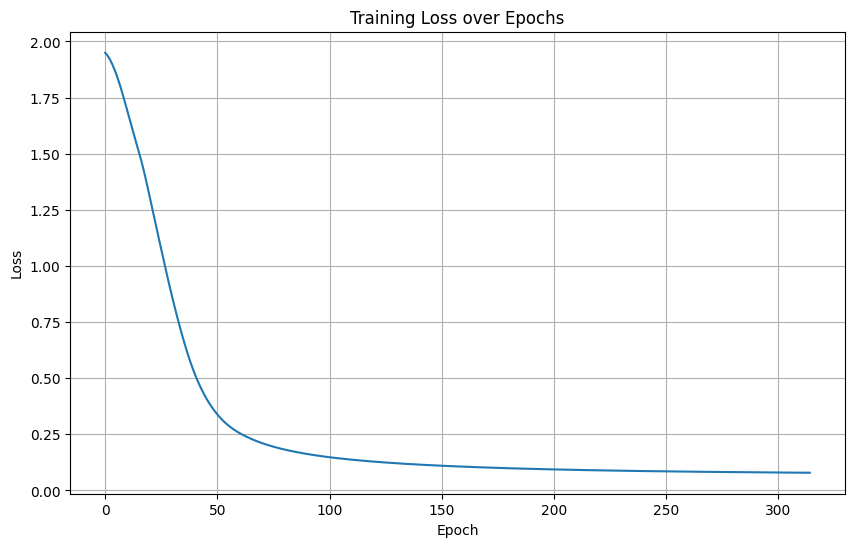

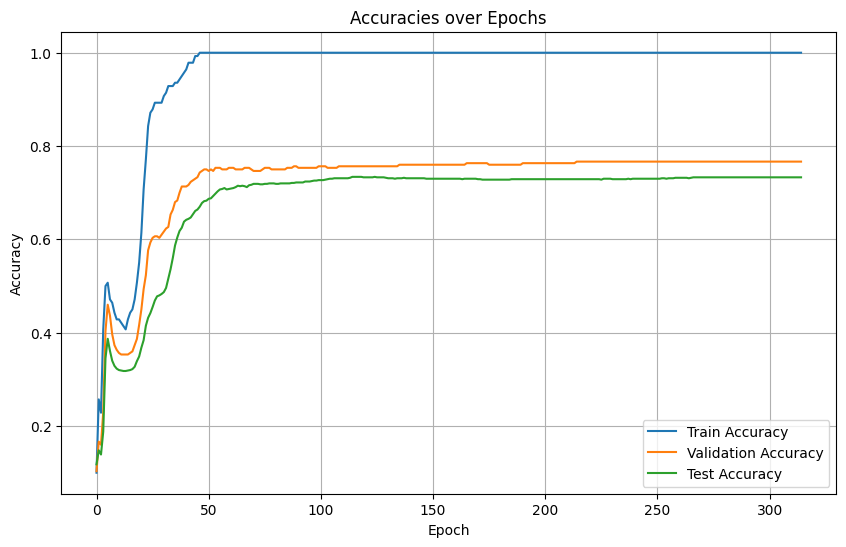

In [55]:
# prompt: add some visulaization of the losses, accuracies

import matplotlib.pyplot as plt

# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracies over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
# prompt: show some correct classification on the test data

gcn.eval()
output = gcn(features, adj)
test_output = output[idx_test]
test_labels = labels[idx_test]

predicted_labels = test_output.max(1)[1].type_as(test_labels)

correctly_classified_indices = (predicted_labels == test_labels).nonzero(as_tuple=True)[0]
incorrectly_classified_indices = (predicted_labels != test_labels).nonzero(as_tuple=True)[0]

print("Examples of correct classifications on the test data:")
for i in correctly_classified_indices[:10]: # Display up to 10 examples
    node_index_in_test_set = i.item()
    actual_node_index = idx_test[node_index_in_test_set].item()

    predicted_class_index = predicted_labels[i].item()
    actual_class_index = test_labels[i].item()

    predicted_class_name = classes[predicted_class_index]
    actual_class_name = classes[actual_class_index]

    print(f"Node Index (in original dataset): {actual_node_index}, Predicted Class: {predicted_class_name}, Actual Class: {actual_class_name}")


Examples of correct classifications on the test data:
Node Index (in original dataset): 500, Predicted Class: Reinforcement_Learning, Actual Class: Reinforcement_Learning
Node Index (in original dataset): 501, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 502, Predicted Class: Reinforcement_Learning, Actual Class: Reinforcement_Learning
Node Index (in original dataset): 503, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 504, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 505, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 507, Predicted Class: Rule_Learning, Actual Class: Rule_Learning
Node Index (in original dataset): 508, Predicted Class: Rule_Learning, Actual Class: Rule_Learning
Node Index (in original dataset): 512, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 513, Predicted 

In [27]:

print("\nExamples of incorrect classifications on the test data:")
for i in incorrectly_classified_indices[:10]: # Display up to 10 examples
    node_index_in_test_set = i.item()
    actual_node_index = idx_test[node_index_in_test_set].item()

    predicted_class_index = predicted_labels[i].item()
    actual_class_index = test_labels[i].item()

    predicted_class_name = classes[predicted_class_index]
    actual_class_name = classes[actual_class_index]

    print(f"Node Index (in original dataset): {actual_node_index}, Predicted Class: {predicted_class_name}, Actual Class: {actual_class_name}")




Examples of incorrect classifications on the test data:
Node Index (in original dataset): 506, Predicted Class: Rule_Learning, Actual Class: Reinforcement_Learning
Node Index (in original dataset): 509, Predicted Class: Rule_Learning, Actual Class: Probabilistic_Methods
Node Index (in original dataset): 510, Predicted Class: Case_Based, Actual Class: Genetic_Algorithms
Node Index (in original dataset): 511, Predicted Class: Case_Based, Actual Class: Genetic_Algorithms
Node Index (in original dataset): 518, Predicted Class: Genetic_Algorithms, Actual Class: Rule_Learning
Node Index (in original dataset): 520, Predicted Class: Rule_Learning, Actual Class: Case_Based
Node Index (in original dataset): 522, Predicted Class: Genetic_Algorithms, Actual Class: Rule_Learning
Node Index (in original dataset): 523, Predicted Class: Reinforcement_Learning, Actual Class: Theory
Node Index (in original dataset): 524, Predicted Class: Rule_Learning, Actual Class: Case_Based
Node Index (in original d

In [28]:
# Visualization of classification results
correct_count = len(correctly_classified_indices)
incorrect_count = len(incorrectly_classified_indices)
total_test_samples = len(test_labels)

print(f"\nTotal test samples: {total_test_samples}")
print(f"Correctly classified: {correct_count}")
print(f"Incorrectly classified: {incorrect_count}")


Total test samples: 1000
Correctly classified: 834
Incorrectly classified: 166


To do: How does GCN behave when increasing the hidden feature dimensionality or the number of layers? Does increasing the number of layers help at all?

#GraphSage

In [32]:
def gcn_accuracy(model):
    """
    Perfom a forward pass `y_pred = model(x)` and computes the accuracy
    between `y_pred` and `y_true`.

    It is particuarly tricky to perform batching in GCN.
    As you can see, here the forward pass is performed on the whole graph
    """
    model.eval()
    y_pred = model(features, adj)
    output= y_pred[idx_test]
    # Rename the sliced labels to a local variable name
    local_labels = labels[idx_test]
    preds= output.max(1)[1].type_as(local_labels) # Use the local variable here
    correct = preds.eq(local_labels).double()    # Use the local variable here
    correct=correct.sum()
    acc = correct / len(local_labels)           # Use the local variable here
    print(f"Accuracy: {acc:.5}")
    return acc